In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_device(device)

In [48]:
# read in all the words
words = open('hindi.txt', 'r').read().split()
words = [
    w
    for w in words
]
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

196203
39
['पीटर', 'लीवर', 'जन्म', 'सितंबर', 'टोडमॉर्डन', 'यॉर्कशायर', 'इंग्लैंड', 'एक']


In [49]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['~'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'ँ', 2: 'ं', 3: 'ः', 4: 'अ', 5: 'आ', 6: 'इ', 7: 'ई', 8: 'उ', 9: 'ऊ', 10: 'ऋ', 11: 'ऍ', 12: 'ऎ', 13: 'ए', 14: 'ऐ', 15: 'ऑ', 16: 'ओ', 17: 'औ', 18: 'क', 19: 'ख', 20: 'ग', 21: 'घ', 22: 'ङ', 23: 'च', 24: 'छ', 25: 'ज', 26: 'झ', 27: 'ञ', 28: 'ट', 29: 'ठ', 30: 'ड', 31: 'ढ', 32: 'ण', 33: 'त', 34: 'थ', 35: 'द', 36: 'ध', 37: 'न', 38: 'ऩ', 39: 'प', 40: 'फ', 41: 'ब', 42: 'भ', 43: 'म', 44: 'य', 45: 'र', 46: 'ऱ', 47: 'ल', 48: 'ळ', 49: 'ऴ', 50: 'व', 51: 'श', 52: 'ष', 53: 'स', 54: 'ह', 55: '़', 56: 'ऽ', 57: 'ा', 58: 'ि', 59: 'ी', 60: 'ु', 61: 'ू', 62: 'ृ', 63: 'ॄ', 64: 'ॅ', 65: 'ॆ', 66: 'े', 67: 'ै', 68: 'ॉ', 69: 'ॊ', 70: 'ो', 71: 'ौ', 72: '्', 73: 'ॐ', 74: 'ॠ', 75: '।', 76: '॥', 77: '०', 78: '१', 79: '२', 80: '३', 81: '४', 82: '५', 83: '६', 84: '७', 85: '८', 86: '९', 87: '॰', 0: '~'}
88


In [50]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '~':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([860014, 8]) torch.Size([860014])
torch.Size([106152, 8]) torch.Size([106152])
torch.Size([108540, 8]) torch.Size([108540])


In [51]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

~~~~~~~~ --> प
~~~~~~~प --> ी
~~~~~~पी --> ट
~~~~~पीट --> र
~~~~पीटर --> ~
~~~~~~~~ --> ल
~~~~~~~ल --> ी
~~~~~~ली --> व
~~~~~लीव --> र
~~~~लीवर --> ~
~~~~~~~~ --> ज
~~~~~~~ज --> न
~~~~~~जन --> ्
~~~~~जन् --> म
~~~~जन्म --> ~
~~~~~~~~ --> स
~~~~~~~स --> ि
~~~~~~सि --> त
~~~~~सित --> ं
~~~~सितं --> ब


In [52]:
# Near copy paste of the layers we have developed in Part 3
import torch.nn.functional as F
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------


# Update the Sequential class
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self.training = True
    
    def __call__(self, x):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = self.training
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def eval(self):
        self.training = False
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False
    
    def train(self):
        self.training = True
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True


In [53]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

85912


In [54]:
# same optimization as last time
max_steps = 200000
batch_size = 24
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 60000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 4.4834
  10000/ 200000: 1.2924
  20000/ 200000: 1.6499
  30000/ 200000: 2.2427
  40000/ 200000: 2.3805
  50000/ 200000: 2.4214
  60000/ 200000: 2.1894
  70000/ 200000: 1.4630
  80000/ 200000: 1.7994
  90000/ 200000: 1.4288
 100000/ 200000: 1.4152
 110000/ 200000: 1.5307
 120000/ 200000: 1.8754
 130000/ 200000: 1.3436
 140000/ 200000: 2.1834
 150000/ 200000: 1.5149
 160000/ 200000: 1.4908
 170000/ 200000: 1.6004
 180000/ 200000: 1.5851
 190000/ 200000: 1.5797


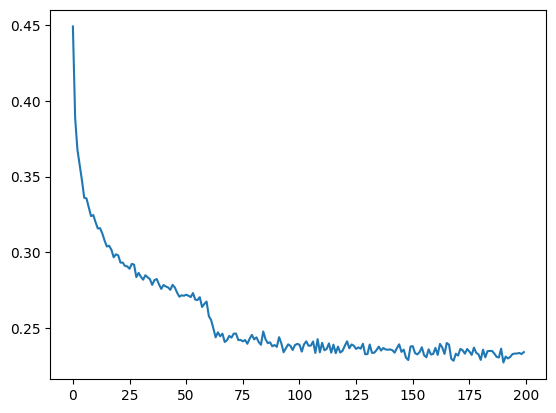

In [55]:
import torch
import matplotlib.pyplot as plt

# Assuming lossi is a list of losses stored as tensors on the GPU
loss_tensor = torch.tensor(lossi).view(-1, 1000).mean(1)

# Move the tensor to the CPU
loss_tensor_cpu = loss_tensor.cpu()

# Convert the tensor to a NumPy array
loss_numpy = loss_tensor_cpu.numpy()

# Plot using Matplotlib
plt.plot(loss_numpy)
plt.show()


In [56]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [57]:
# # evaluate the loss
# @torch.no_grad() # this decorator disables gradient tracking inside pytorch
# def split_loss(split):
#   x,y = {
#     'train': (Xtr, Ytr),
#     'val': (Xdev, Ydev),
#     'test': (Xte, Yte),
#   }[split]
#   logits = model(x)
#   loss = F.cross_entropy(logits, y)
#   print(split, loss.item())

# split_loss('train')
# split_loss('val')

In [58]:
# # sample from the model
# for _ in range(15):
    
#     out = []
#     context = [0] * block_size # initialize with all ...
#     # context = [stoi[i] for i in "मुख्याल"]
#     # print(context)
#     while True:
#       # forward pass the neural net
#       logits = model(torch.tensor([context]))
#       probs = F.softmax(logits, dim=1)
#       # sample from the distribution
#       ix = torch.multinomial(probs, num_samples=1).item()
#       # shift the context window and track the samples
#       context = context[1:] + [ix]
#       out.append(ix)
#       # if we sample the special '.' token, break
#       if ix == 0:
#         break
    
#     print(''.join(itos[i] for i in out)) # decode and print the generated word

In [60]:
# Updated text generation function
def generate_text(model, seed_text, num_words=5):
    model.eval()  # Set the model to evaluation mode
    
    for _ in range(num_words):
        context = [0] * block_size
        for ch in seed_text[-block_size:]:
            context = context[1:] + [stoi.get(ch, 0)]
        
        out = []
        while True:
            # Convert context to tensor and add batch dimension
            x = torch.tensor([context])
            
            # Forward pass through the model
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            
            # Sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            
            # Shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            
            # Break if we sample the special '~' token (assuming '~' is the end token)
            if ix == 0:
                break
        
        word = ''.join(itos[i] for i in out[:-1])  # Exclude the '~' token
        seed_text += word + ' '
    
    return seed_text.strip()

# Array of Hindi words
hindi_words = ['नमस्ते', 'संपर्क', 'ज्ञान', 'अनुभव', 'कृपया', 'धन्य']

# Loop through the array and generate text for each word
for word in hindi_words:
    # Generate text
    generated_text = generate_text(model, word)
    
    # Print the generated text
    print(f"Generated text from '{word}' ---> {generated_text}")

Generated text from 'नमस्ते' ---> नमस्ते   प्रमुख स
Generated text from 'संपर्क' ---> संपर्क ्य टेसी  ओं
Generated text from 'ज्ञान' ---> ज्ञान शों न मूलियटी
Generated text from 'अनुभव' ---> अनुभव  द ये ्रेह
Generated text from 'कृपया' ---> कृपया  मोन  क
Generated text from 'धन्य' ---> धन्यों युद्ध ओं
